In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap

In [2]:
import numpy as np

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import warnings

In [6]:
warnings.filterwarnings('ignore')

In [7]:
import seaborn as sns

In [8]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm

In [9]:
from scipy.stats import kde

In [10]:
from tqdm import tqdm_notebook

In [11]:
from scipy.optimize import minimize

## синтезирую задачу

In [12]:
x_class0 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([5, 5])

In [13]:
x_class1 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([5, -5])

In [14]:
x_class2 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([-5, -5])

In [15]:
x_class3 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([-5, 5])

In [16]:
nbins = 300
xmesh, ymesh = np.mgrid[-15:15:nbins*1j, -15:15:nbins*1j]

In [17]:
rv = mnorm([5, 5], [[2.0, 0.0], [0.0, 3.0]])
norm_class0 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [18]:
rv = mnorm([5, -5], [[3.0, 0.0], [0.0, 2.0]])
norm_class1 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [19]:
rv = mnorm([-5, -5], [[2.0, 0.0], [0.0, 3.0]])
norm_class2 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [20]:
rv = mnorm([-5, 5], [[3.0, 0.0], [0.0, 2.0]])
norm_class3 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [21]:
y = np.squeeze(np.concatenate([np.zeros((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int)*2,
                               np.ones((1000,1), dtype=int)*3],
                              axis=0))

In [22]:
x = np.concatenate([x_class0, x_class1, x_class2, x_class3], axis=0)
x.shape

(4000, 2)

In [23]:
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'gray'}

In [24]:
cmaps = ['Reds', 'Greens', 'Blues', 'Greys']

In [25]:
clabels = [colors[l] for l in y]

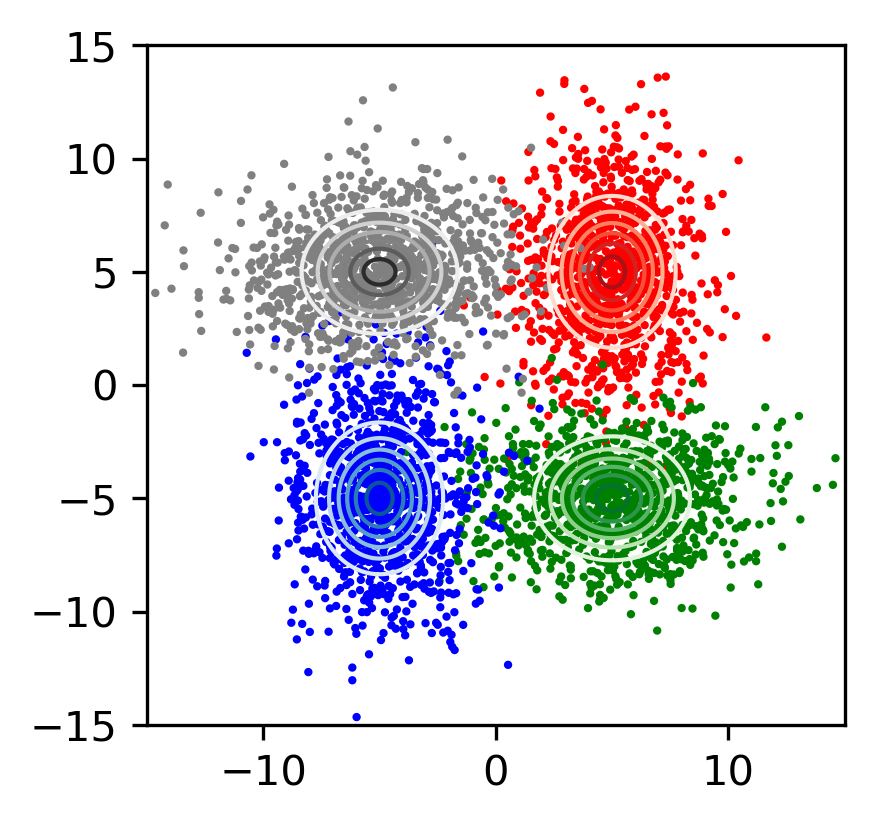

In [26]:
f = plt.figure(figsize=(3,3), dpi=300)
plt.scatter(x[:,0], x[:,1], s=1, c=clabels)
for class_label,norm in zip([0,1,2,3],
                            [norm_class0, norm_class1, norm_class2, norm_class3]):
    _ = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)

In [27]:
def one_hot(arr):
    classes = np.unique(y)
    num_classes = len(classes)
    return classes,np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [28]:
classes, y_oh = one_hot(y)

In [29]:
classes

array([0, 1, 2, 3])

In [30]:
y_oh

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

## Мультиномиальная логистическая регрессия своими руками

#### implementing loss function and its gradient w.r.t. parameters $\theta$

In [31]:
# stable Softmax

def softmax(z):
    z_clipped = z-z.max()
    log_softmax = z_clipped - jnp.log(jnp.sum(jnp.exp(z_clipped), axis=-1, keepdims=True))
    softmax_values = jnp.exp(log_softmax)
    return softmax_values

In [32]:
def compute_probabilities(X_matrix, theta):
    z = jnp.dot(X_matrix, theta)
    p = softmax(z)
    return p

In [33]:
def multinomial_cross_entropy(p_pred, y_true):
    return -jnp.sum(jnp.multiply(y_true, jnp.log(p_pred)), axis=-1, keepdims=True)

In [34]:
def multinomial_cross_entropy_loss(X, y, curr_theta):
    theta_matr = jnp.reshape(curr_theta, (X.shape[1]+1, 4))
    X_0 = jnp.ones((X.shape[0], 1), dtype=jnp.float64)
    X_matrix = jnp.concatenate([X_0, X], axis=1)    # N x f
    p = compute_probabilities(X_matrix, theta_matr) # N x K
    l = multinomial_cross_entropy(p, y)
    return jnp.squeeze(jnp.mean(l, axis=0, keepdims=True))

In [35]:
loss_fn = jit(multinomial_cross_entropy_loss)

In [36]:
grad_fn = jit(grad(loss_fn, argnums=2))

In [37]:
theta_start = np.random.randn(x.shape[1]+1, 4).flatten()
theta_start.shape

(12,)

In [38]:
theta_start

array([ 1.48333285, -0.1396833 , -0.71731807, -1.49741557, -0.62582379,
        0.07832011,  0.36876671,  1.91187084,  1.55188671,  1.13031573,
        0.76497451,  0.53289626])

In [39]:
curr_loss = loss_fn(x,y_oh,theta_start)
curr_loss

DeviceArray(10.327739, dtype=float32)

In [40]:
curr_loss_grad = grad_fn(x,y_oh,theta_start)
curr_loss_grad.shape

(12,)

In [41]:
curr_loss_grad

DeviceArray([ 0.2507256 , -0.22502069, -0.20433319,  0.17862818,
             -3.41359   , -1.2965902 ,  1.1052985 ,  3.604881  ,
             -0.4264154 ,  1.2015835 ,  0.88913643, -1.664304  ],            dtype=float32)

In [42]:
loss_history = []
optimization_result = minimize(lambda t: float(loss_fn(x, y_oh, t)),
                               theta_start,
                               jac = lambda t: np.array(grad_fn(x, y_oh, t)).flatten(),
                               callback = lambda t: loss_history.append(float(loss_fn(x,y_oh,t))))

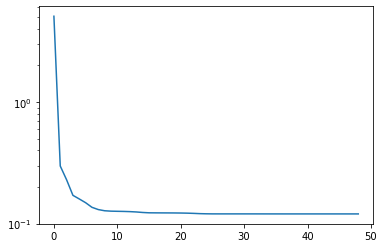

In [43]:
plt.plot(loss_history)
plt.yscale('log')

In [44]:
theta_matr = jnp.reshape(optimization_result.x, (x.shape[1]+1, 4))

In [45]:
theta_matr

array([[-0.06226769, -0.41296818,  0.200731  , -0.59657899],
       [ 1.35106927,  1.18487854, -0.46530178, -0.33751256],
       [ 1.66994674,  0.04055476,  0.31673103,  1.95283924]])

In [46]:
X_0 = jnp.ones((x.shape[0], 1), dtype=np.float64)
X_matrix = np.concatenate([X_0, x], axis=1)
pred_proba = compute_probabilities(X_matrix, theta_matr)

In [47]:
y_pred = classes[np.argmax(pred_proba, axis=1)]

In [48]:
y

array([0, 0, 0, ..., 3, 3, 3])

In [49]:
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [51]:
print('Accuracy: %f' % np.mean(y_pred == y))

Accuracy: 0.956500


In [52]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

### Multinomial logistic regression implementation (without any regularizations, with default optimization parameters)

In [53]:
class MultinomialLogRegression:
    def __init__(self):
        self.theta = None
    
    def softmax(self, z):
        z_clipped = z-z.max()
        log_softmax = z_clipped - jnp.log(jnp.sum(jnp.exp(z_clipped), axis=-1, keepdims=True))
        softmax_values = jnp.exp(log_softmax)
        return softmax_values
    
    def compute_probabilities(self, X_matrix, theta):
        z = jnp.dot(X_matrix, theta)
        p = self.softmax(z)
        return p
    
    def multinomial_cross_entropy(self, p_pred, y_true):
        return -jnp.sum(jnp.multiply(y_true, jnp.log(p_pred)), axis=-1, keepdims=True)
    
    def multinomial_cross_entropy_loss(self, X, y, curr_theta):
        theta_matr = jnp.reshape(curr_theta, (X.shape[1]+1, len(self.classes)))
        X_0 = jnp.ones((X.shape[0], 1), dtype=jnp.float64)
        X_matrix = jnp.concatenate([X_0, X], axis=1)
        p = self.compute_probabilities(X_matrix, theta_matr)
        l = self.multinomial_cross_entropy(p, y)
        return jnp.squeeze(jnp.mean(l, axis=0, keepdims=True))
    
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (y.ndim == 1), "y should be 1-dimensional"
        
        self.classes,y_onehot = one_hot(y)
        
        self.loss_fn = jit(self.multinomial_cross_entropy_loss)
        self.grad_fn = jit(grad(self.loss_fn, argnums=2))
        
        theta_start = np.random.randn(X.shape[1]+1, len(self.classes)).flatten()
        loss_history = []
        optimization_result = minimize(lambda t: float(self.loss_fn(X, y_onehot, t)),
                                       theta_start,
                                       jac = lambda t: np.array(self.grad_fn(X, y_onehot, t)).flatten(),
                                       callback = lambda t: loss_history.append(float(self.loss_fn(X, y_onehot, t))))
        
        self.theta = optimization_result.x
        return loss_history
    
    def predict(self, X, return_proba = False):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (self.theta is not None), "parameters are None. perhaps, you should fit the model first."
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        theta_matr = jnp.reshape(self.theta, (X.shape[1]+1, len(self.classes)))
        pred_proba = self.compute_probabilities(X_matrix, theta_matr)
        y_pred = self.classes[np.argmax(pred_proba, axis=1)]
        
        if return_proba:
            return y_pred, pred_proba
        else:
            return y_pred

In [54]:
sample_size = x.shape[0]
Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
MLR = MultinomialLogRegression()
MLR.fit(Xtrain, ytrain)
yoob_pred,yoob_proba = MLR.predict(Xoob, return_proba=True)
print('accuracy: ' + str(np.mean(np.squeeze(yoob_pred)==yoob)))

accuracy: 0.9551325628823929


In [55]:
B = 1000
sample_size = x.shape[0]
acc = []
for i in tqdm_notebook(range(B), total=B):
    Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
    MLR = MultinomialLogRegression()
    _ = MLR.fit(Xtrain, ytrain)
    yoob_pred,yoob_proba = MLR.predict(Xoob, return_proba=True)
    acc.append(np.mean(np.squeeze(yoob_pred)==yoob))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
acc = np.array(acc)

отбросим экстремальные значения распределения величины Accuracy - считаем их выбросами.

In [64]:
acc = acc[((acc>=np.percentile(acc, 1)) & (acc<=np.percentile(acc, 99)))]

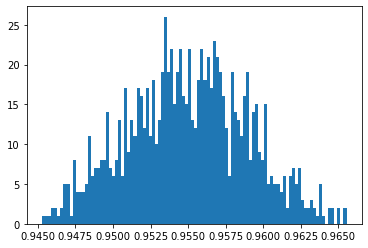

In [65]:
_ = plt.hist(acc, bins=100)

In [57]:
np.array(acc).mean()

0.9525753035311715

Распределение Accuracy похоже на нормальное. Мы точно знаем, что это не так: у величины Accuracy область значений ограничена снизу значением `0` и сверху значением `1`. Для величины, распределенной нормально, область значений совпадает с множеством действительных чисел, не ограничено сверху и снизу.

Но в это же время мы можем аппроксимировать плотность распределения величины Accuracy плотностью распределения нормальной случайной величины. Если на полученной выборке применить тест Колмогорова-Смирнова, мы увидим, что с высоким уровнем значимости указанная выборка значений Accuracy подчиняется нормальному распределению.

Исходя из этого предположения, оценим доверительный интервал как для нормально распределенной случайной величины.

In [67]:
1.65*np.array(acc).std()

0.006571743538947243

Итак, доверительный интервал для случайной величины Accuracy в предположении, что она распределена нормально, следующий:

In [72]:
lower_bound = acc.mean() - 1.65*acc.std()
upper_bound = acc.mean() + 1.65*acc.std()
print('95%% confidence interval: [%f; %f]' % (lower_bound, upper_bound))

95% confidence interval: [0.948437; 0.961580]


Чуть более достоверная оценка доверительного интервала - оценить выборочные квантили уровней `0.025` и `0.975`.

Пояснение: нами было осуществлено 1000 заходов на обучение на различных bootstrap-выборках и, соответственно, получено 1000 оценок качества на out-of-bag выборках. Каждая оценка качества - реализация случайной величины Accuracy. У этой величины есть плотность распределения и функция распределения. По выборке можно оценить (приближенно) квантили эмпирического распределения случайной величины Accuracy. Определяем по выборке => это выборочные оценки.

Интервал между квантилями уровней `0.025` и `0.975` - это и есть доверительный интервал с уровнем доверия 95%.

In [74]:
print('95%% confidence interval: [%f; %f]' % tuple(np.percentile(acc, [2.5, 97.5])))

95% confidence interval: [0.947368; 0.962623]


видим, что выборочная оценка доверительного интервала чуть шире по сравнению с оценкой, проведенной в предположении, что Accuracy распределена нормально.

## то же самое, но с использованием sklearn

##### Просто чтобы удостовериться, что наш код работает так же, как у остальных $N$ тысяч специалистов, которые не будут утруждаться реализовывать модель логистической регрессии самостоятельно

In [75]:
from sklearn.linear_model import LogisticRegression

In [76]:
lrmodel = LogisticRegression()

In [77]:
lrmodel.fit(Xtrain, ytrain)

LogisticRegression()

In [78]:
yoob_pred_sk = lrmodel.predict(Xoob)
yoob_proba_sk = lrmodel.predict_proba(Xoob)

##### сверим результаты

In [79]:
np.mean(np.squeeze(yoob_pred) == yoob_pred_sk)

1.0

## voilà ↑
Наша реализация модели мультиномиальной логистической регрессии на этих простых данных дает в точности такие же результаты, как и реализация в пакете `scikit-learn`.

### Отобразим оценки вероятностей в пространстве признаков

In [80]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [81]:
preds_mesh,probas_mesh = MLR.predict(x_test_mesh, return_proba=True)

In [82]:
preds_mesh = preds_mesh.reshape(xmesh.shape)
probas_mesh = probas_mesh.reshape(list(xmesh.shape) + [4])

In [83]:
xmesh[preds_mesh==0].shape

(22478,)

In [84]:
ymesh[preds_mesh==0].shape

(22478,)

In [85]:
probas_mesh[:,:,0][preds_mesh==0].shape

(22478,)

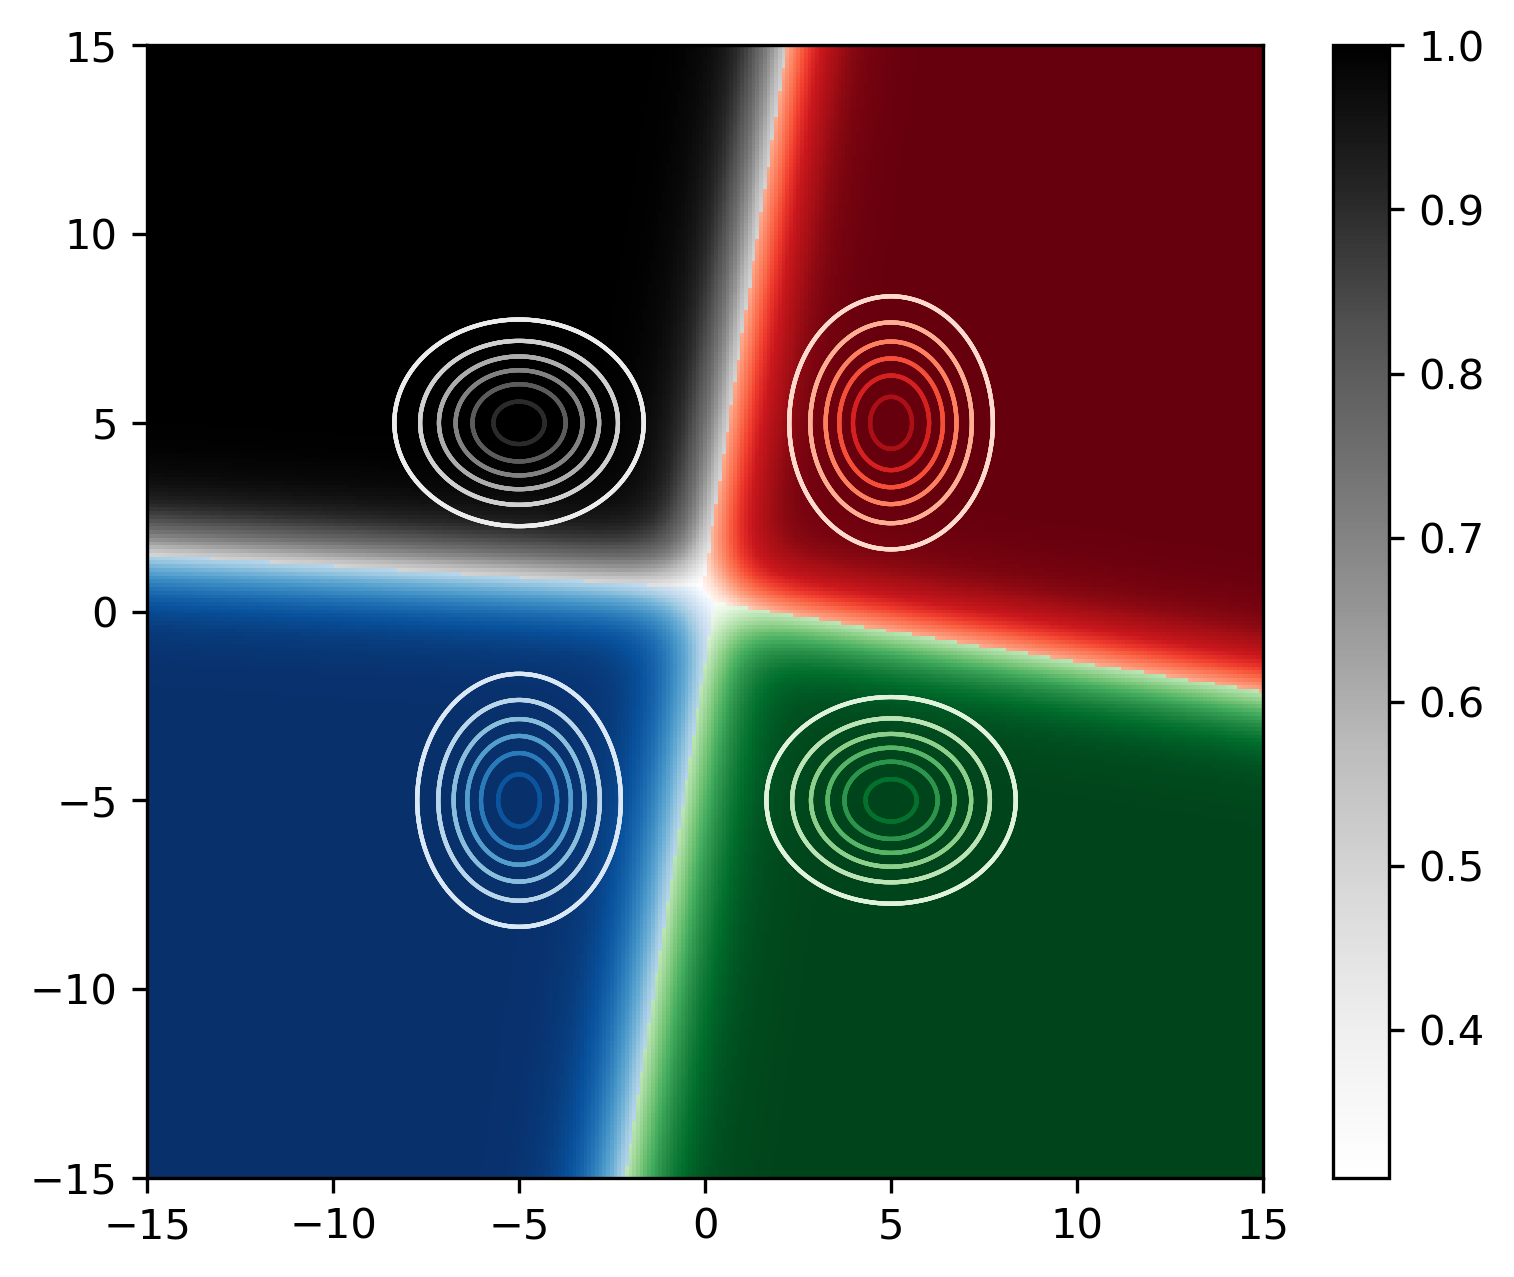

In [90]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
plt.colorbar(pcolormeshplot)

### Отобразим вероятности классов в некоторых интересных сечениях

In [105]:
p0 = np.array([5, 5])
p1 = np.array([5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [106]:
preds_linspace,probas_linspace = MLR.predict(linspace, return_proba=True)

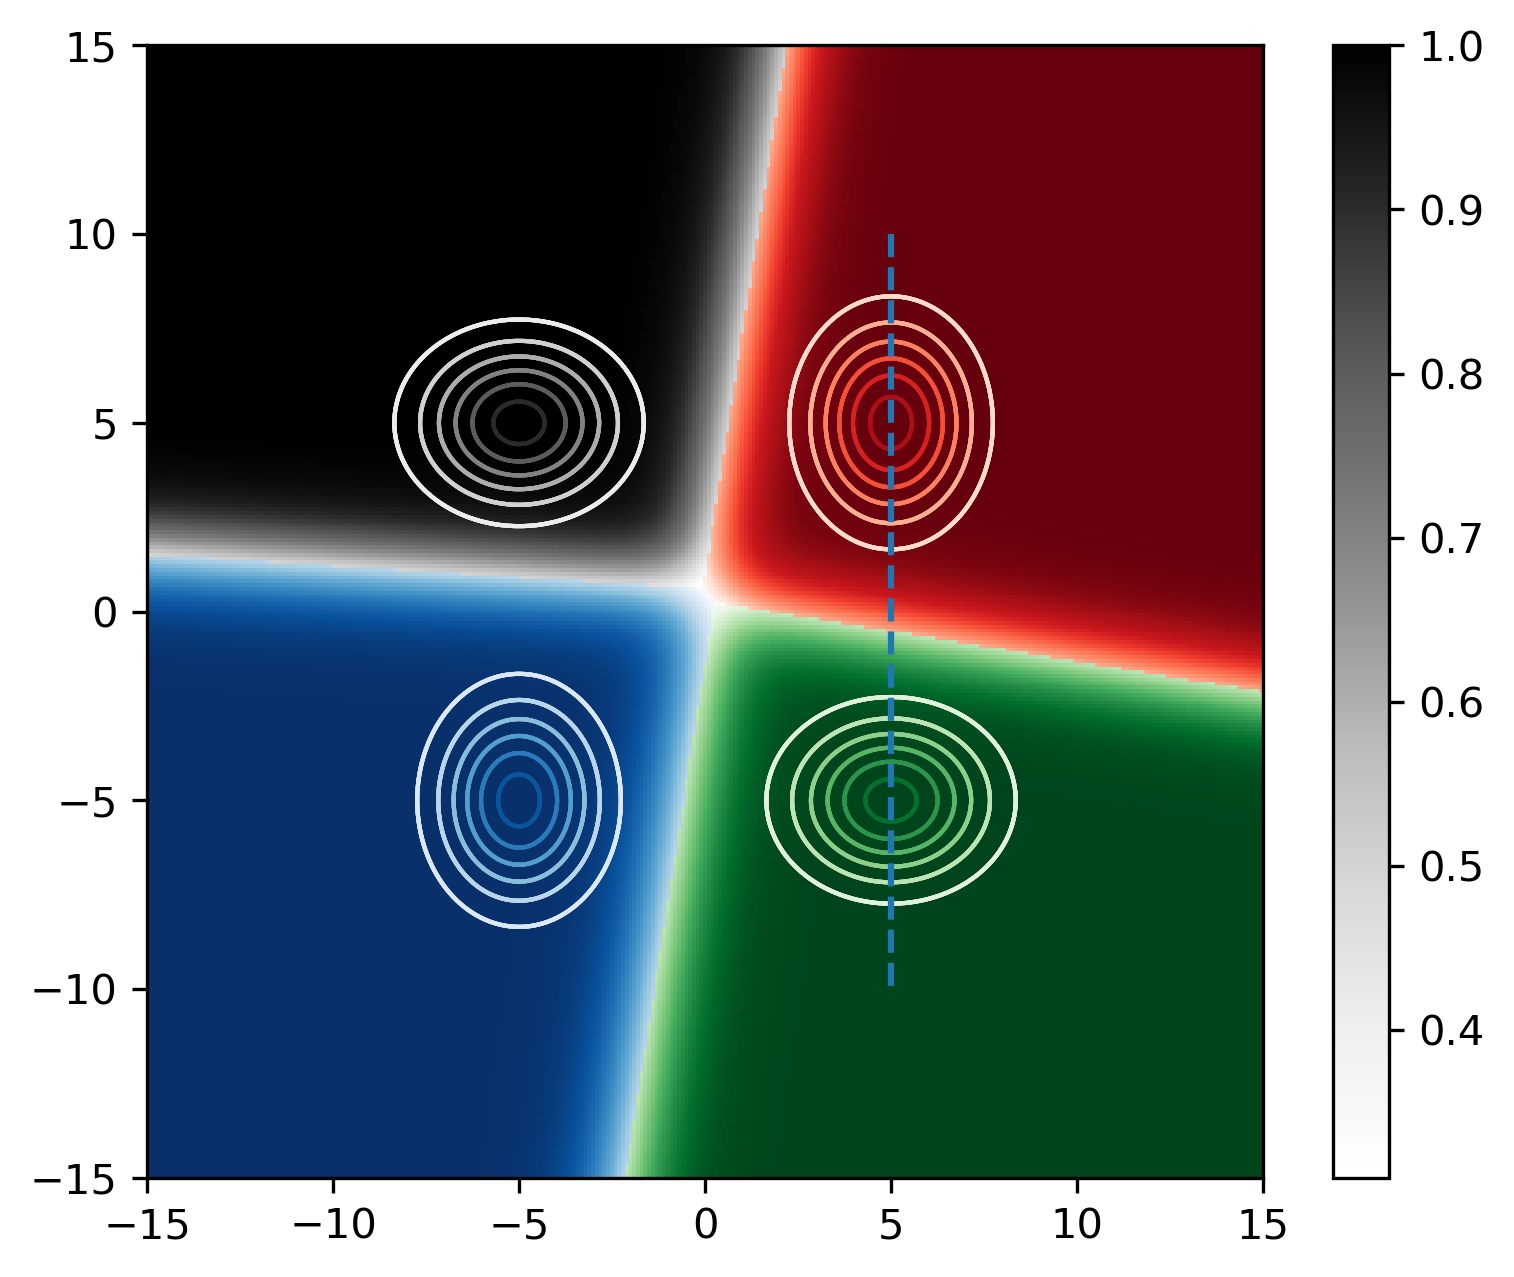

In [107]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

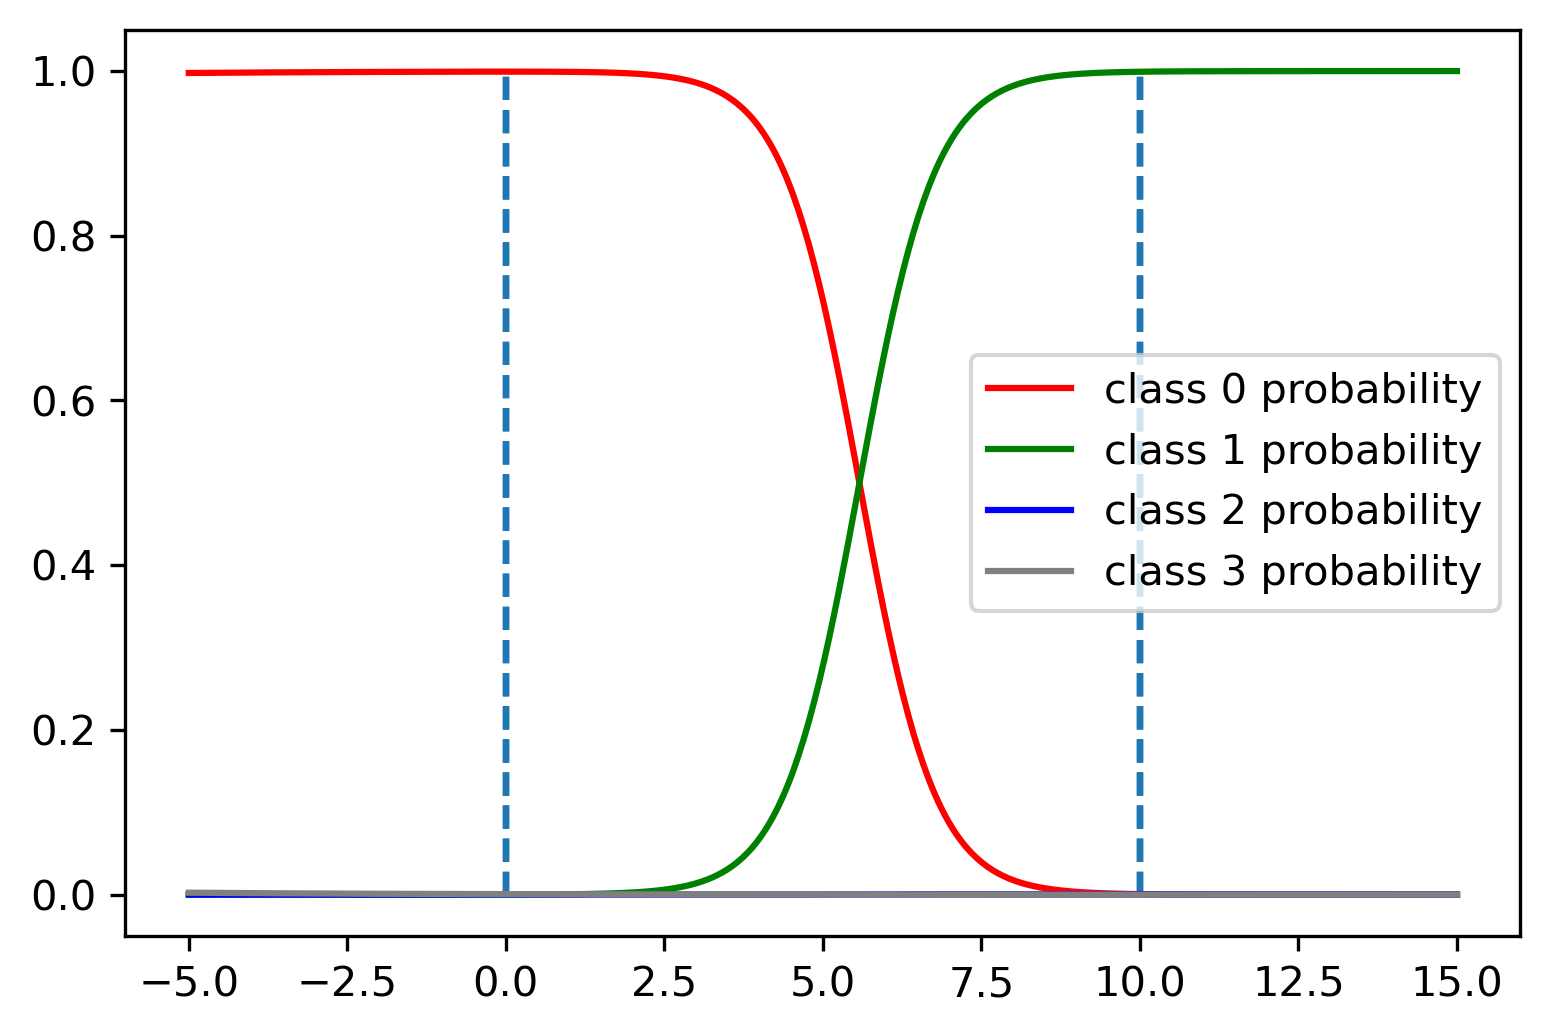

In [111]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)],
                   0.0, 1.0, linestyles='dashed')
plt.legend()

In [112]:
p0 = np.array([5, 5])
p1 = np.array([-5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [113]:
preds_linspace,probas_linspace = MLR.predict(linspace, return_proba=True)

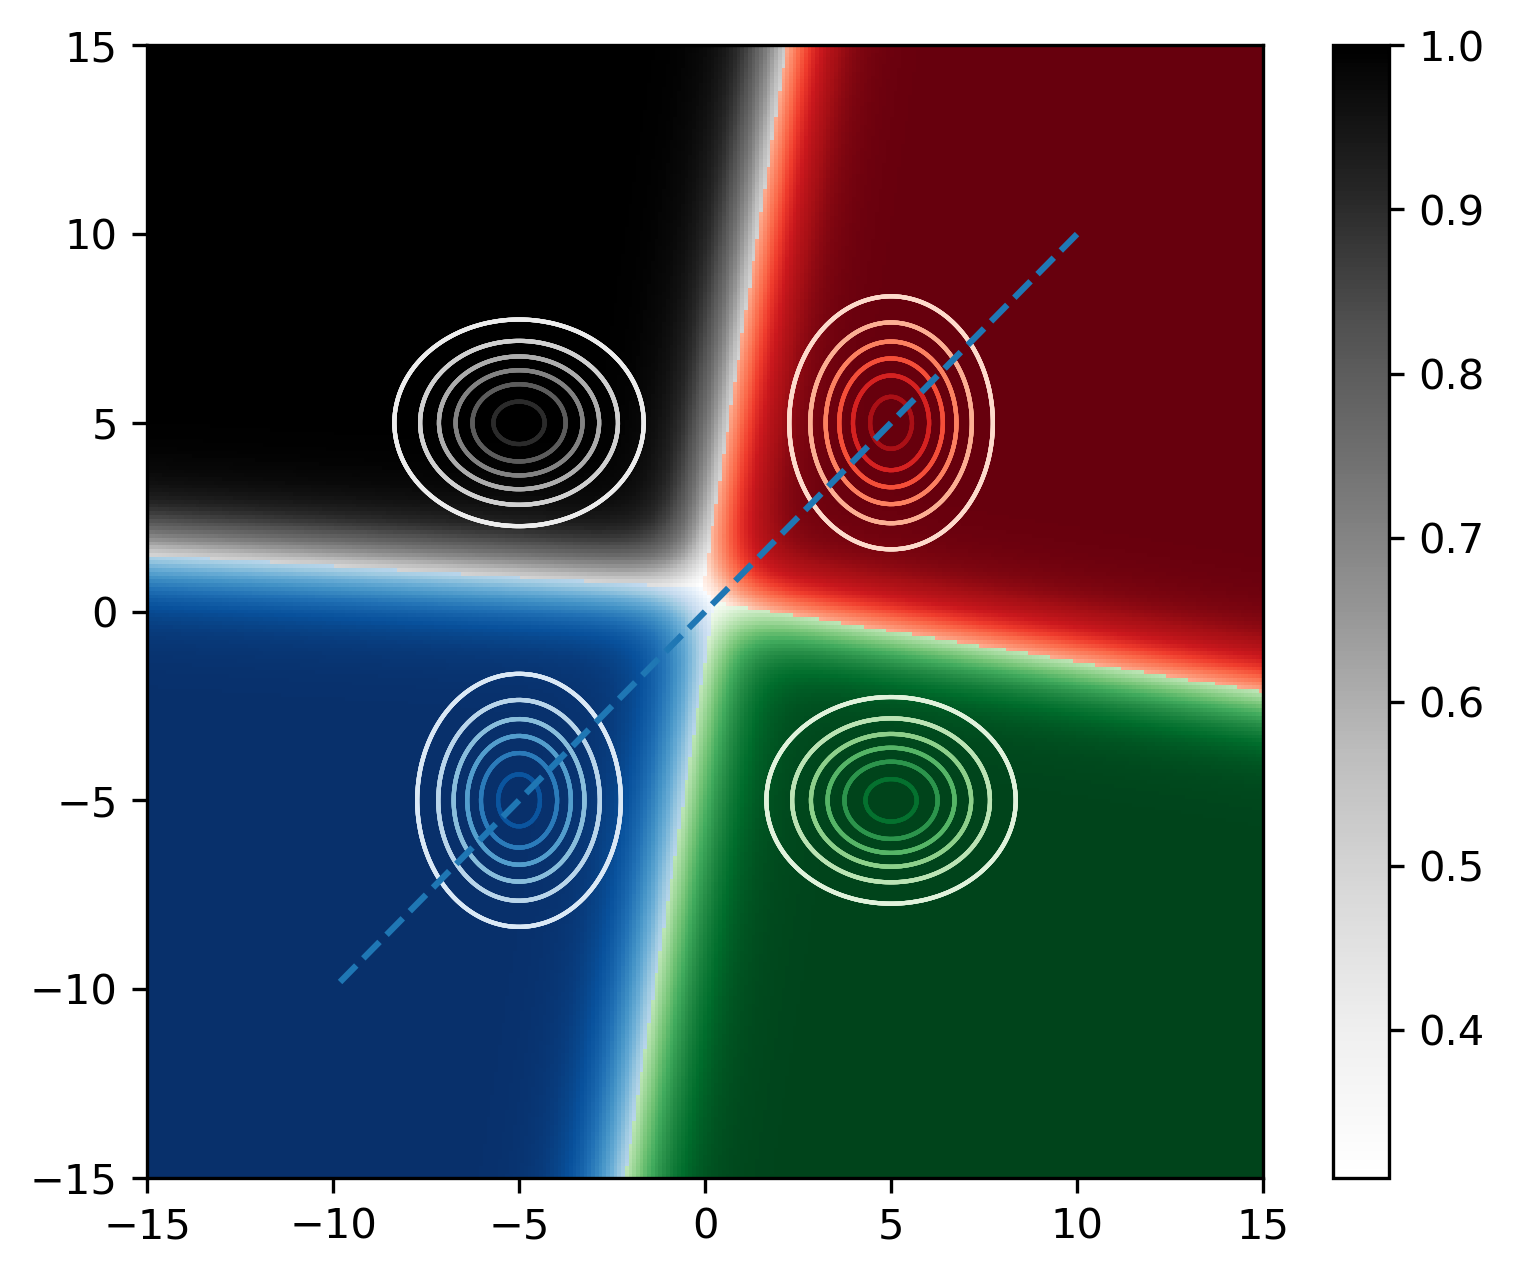

In [114]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

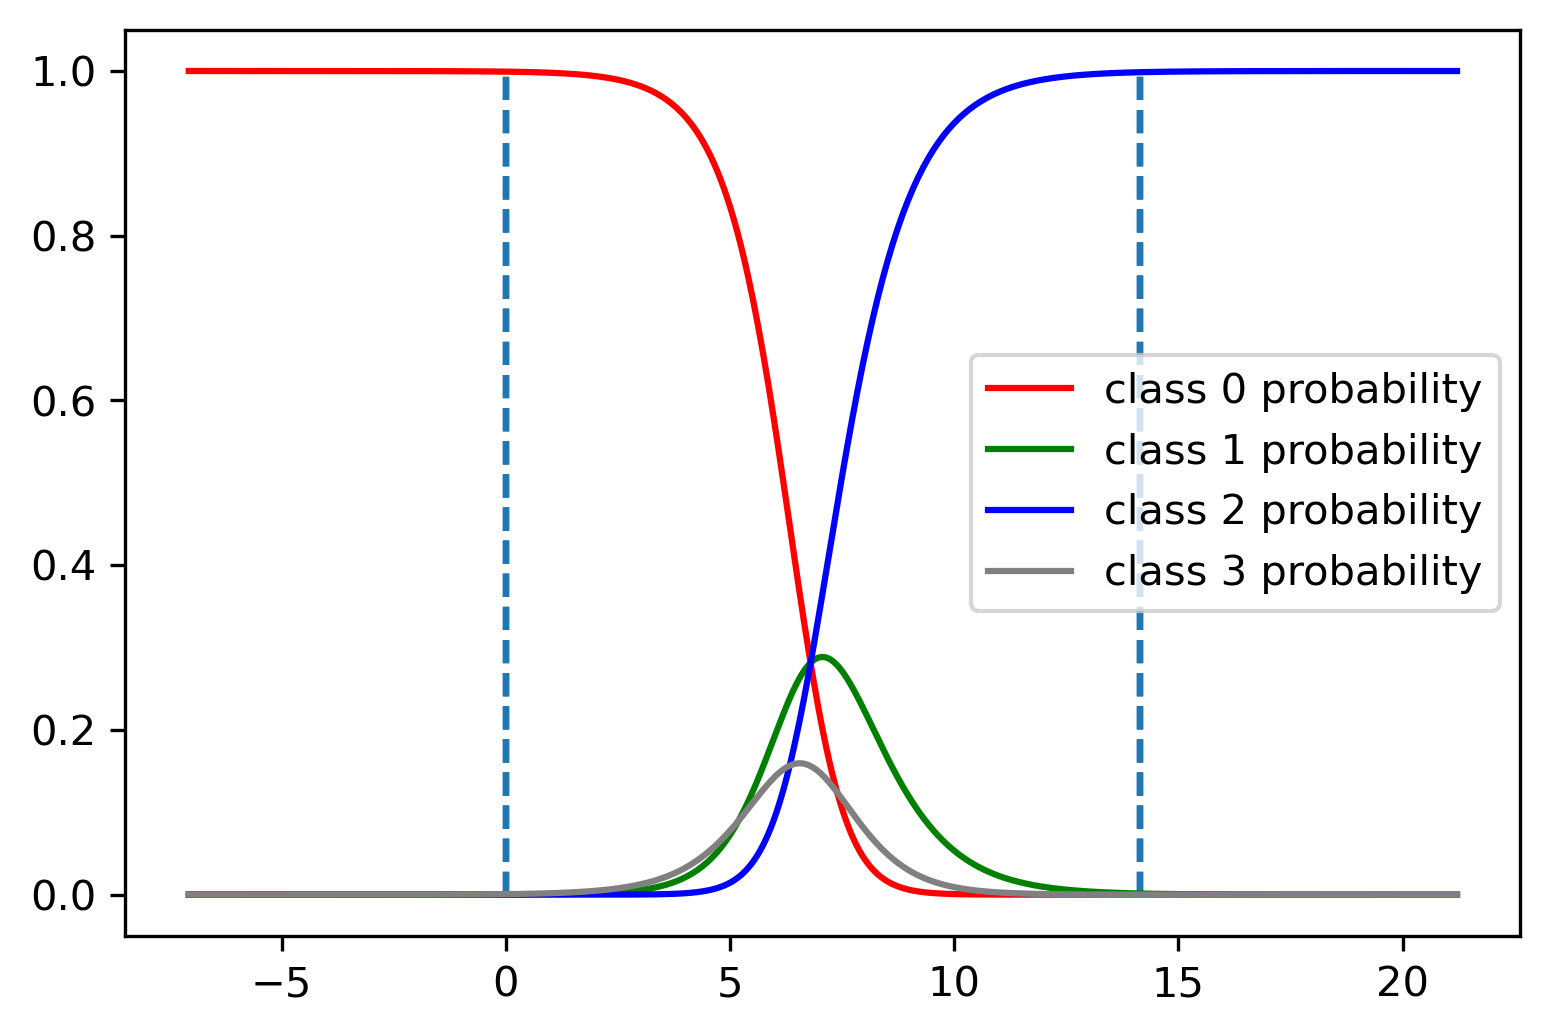

In [115]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)], 0.0, 1.0, linestyles='dashed')
plt.legend()